In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd

In [34]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.types import DateTime
from sqlalchemy import create_engine, func, desc, inspect

In [36]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [41]:
# Get column names
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [42]:
columns1 = inspector.get_columns('station')
for c in columns1:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date = pd.DataFrame(session.query(Measurement.date).\
    filter(func.strftime("%m", Measurement.date)).all())

#Get latest date
late_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
late_date

('2017-08-23')

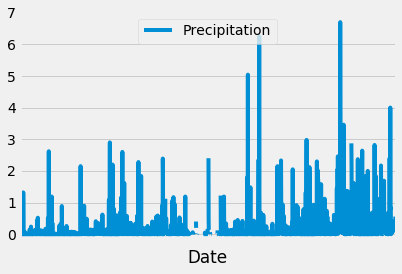

In [44]:
# Calculate the date 1 year ago from the last data point in the database

query_date = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).all()
    
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precip, columns=['Date', 'Precipitation'])
df.dropna()
df.set_index('Date', inplace=True)
# Sort the dataframe by date
df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
ax =df.plot(xticks=[])
ax.legend(loc='upper center')
#I feel certain I have the right data for this graph, YET-
# it doesn't seem to match the provided image...

![precipitation](Images/precipitation.png)

In [45]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [46]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station, Measurement.date).\
    group_by(Measurement.station).count()
station_count


9

In [47]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_groups = session.query(Measurement.station, func.count(Measurement.station).label('Count')).\
    group_by(Measurement.station).order_by(desc('Count'))
for x in station_groups:
    print(x)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [48]:
# I couldn't tell from the instructions if we were to pull the min, max, avg from across all stations or JUST the most active
# So I did both...
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_min = session.query(Measurement.station, func.min(Measurement.tobs))

print('The stats for temps across all stations are:')
print('Min:')
for x in station_min:
    print(x)
    print('\n')
print('Max:')
station_max = session.query(Measurement.station, func.max(Measurement.tobs))
for x in station_max:
    print(x) 
    print('\n')
print('Avg:')
station_avg = session.query(Measurement.station, func.avg(Measurement.tobs))
for x in station_avg:
    print(x)
    print('\n')
    
sel = [Measurement.station,
             func.min(Measurement.tobs),
             func.max(Measurement.tobs),
             func.avg(Measurement.tobs)]
active_st = session.query(*sel).\
    filter(Measurement.station == 'USC00519281')
print('The stats for the most active station are:')
print(active_st[0])

The stats for temps across all stations are:
Min:
('USC00511918', 53.0)


Max:
('USC00519397', 87.0)


Avg:
('USC00516128', 73.09795396419437)


The stats for the most active station are:
('USC00519281', 54.0, 85.0, 71.66378066378067)


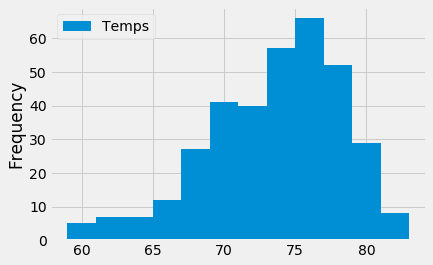

In [49]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_date = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
temps = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(temps, columns=['Temps'])
df.set_index('Temps')
# Sort the dataframe by date
df.sort_values('Temps')
# # Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='hist', bins=12, legend=True)


![precipitation](Images/station-histogram.png)

In [50]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# My trip is for my birthday - 6-6 through 6-13
my_trip = (calc_temps('2016-06-06', '2016-06-13'))
height = my_trip[0][1]
yerr = my_trip[0][0]-my_trip[0][2]


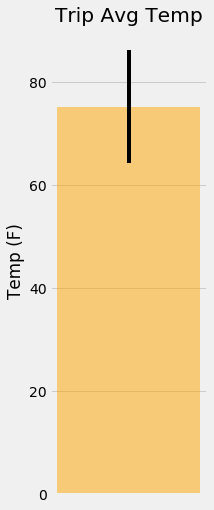

In [52]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
fig.set_size_inches(2.5, 8)
ax.bar(0, height, yerr=yerr, align='edge', color='orange', alpha=.5)
plt.title('Trip Avg Temp')
#ax.set_yticks(np.arange(0, 119, 20))
ax.set_ylabel("Temp (F)")

ax.set_xticklabels([])
ax.grid(axis='x')


In [53]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


st = Base.classes.station
me = Base.classes.measurement

    
sel = [me.date, st.station, me.prcp, st.latitude, st.longitude, st.name, st.elevation]

    
def calc_temps1(start_date, end_date):

    
    return session.query(*sel).filter(st.station == me.station).filter(me.date >= start_date).\
        filter(me.date <= end_date).order_by(desc(me.prcp)).all()

my_trip1 = (calc_temps1('2016-06-06', '2016-06-13'))

my_trip1

[('2016-06-09',
  'USC00516128',
  1.7,
  21.3331,
  -157.8025,
  'MANOA LYON ARBO 785.2, HI US',
  152.4),
 ('2016-06-10',
  'USC00516128',
  1.4,
  21.3331,
  -157.8025,
  'MANOA LYON ARBO 785.2, HI US',
  152.4),
 ('2016-06-07',
  'USC00516128',
  1.26,
  21.3331,
  -157.8025,
  'MANOA LYON ARBO 785.2, HI US',
  152.4),
 ('2016-06-11',
  'USC00516128',
  0.65,
  21.3331,
  -157.8025,
  'MANOA LYON ARBO 785.2, HI US',
  152.4),
 ('2016-06-10',
  'USC00519281',
  0.62,
  21.45167,
  -157.84888999999998,
  'WAIHEE 837.5, HI US',
  32.9),
 ('2016-06-12',
  'USC00516128',
  0.55,
  21.3331,
  -157.8025,
  'MANOA LYON ARBO 785.2, HI US',
  152.4),
 ('2016-06-06',
  'USC00519281',
  0.52,
  21.45167,
  -157.84888999999998,
  'WAIHEE 837.5, HI US',
  32.9),
 ('2016-06-06',
  'USC00516128',
  0.47,
  21.3331,
  -157.8025,
  'MANOA LYON ARBO 785.2, HI US',
  152.4),
 ('2016-06-07',
  'USC00513117',
  0.4,
  21.4234,
  -157.8015,
  'KANEOHE 838.1, HI US',
  14.6),
 ('2016-06-06',
  'USC0051311

In [54]:
# I wanted to clean that up by putting in datafrme

df = pd.DataFrame(my_trip1, columns=['Date', 'Station_ID', 'Precipitation', 'Latitude', 'Longitude', 'Station_Name', 'Elevation'])

df_group = df.groupby(["Precipitation","Station_ID","Date"]).sum()
df_group.sort_values(["Precipitation"], ascending=False)

,,,Latitude,Longitude,Elevation
Precipitation,Station_ID,Date,,,
1.70,USC00516128,2016-06-09,21.33310,-157.80250,152.4
1.40,USC00516128,2016-06-10,21.33310,-157.80250,152.4
1.26,USC00516128,2016-06-07,21.33310,-157.80250,152.4
0.65,USC00516128,2016-06-11,21.33310,-157.80250,152.4
0.62,USC00519281,2016-06-10,21.45167,-157.84889,32.9
0.55,USC00516128,2016-06-12,21.33310,-157.80250,152.4
0.52,USC00519281,2016-06-06,21.45167,-157.84889,32.9
0.47,USC00516128,2016-06-06,21.33310,-157.80250,152.4
0.40,USC00513117,2016-06-07,21.42340,-157.80150,14.6


## Optional Challenge Assignment

In [55]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [56]:

# calculate the daily normals for your trip
j6 = daily_normals("06-06")
j7 = daily_normals("06-07")
j8 = daily_normals("06-08")
j9 = daily_normals("06-09")
j10 = daily_normals("06-10")
j11 = daily_normals("06-11")
j12 = daily_normals("06-12")
j13 = daily_normals("06-13")

# push each tuple of calculations into a list called `normals`
normals = [j6[0], j7[0], j8[0], j9[0], j10[0], j11[0], j12[0], j13[0]]

# Loop through the list of %m-%d strings and calculate the normals for each date
dates = [("06-06"), ("06-07"), ("06-08"), ("06-09"), ("06-10"), ("06-11"), ("06-12"), ("06-13")]
dates

['06-06', '06-07', '06-08', '06-09', '06-10', '06-11', '06-12', '06-13']

In [57]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates = pd.DataFrame(normals, columns = ("Min", "Max", "Avg"))
trip_dates['Trip Dates'] = dates
trip_dates.set_index("Trip Dates")

,Min,Max,Avg
Trip Dates,,,
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0
06-10,68.0,75.142857,81.0
06-11,69.0,76.019608,84.0
06-12,66.0,75.666667,83.0
06-13,68.0,75.666667,81.0


Text(0.5, 0, 'Trip Dates')

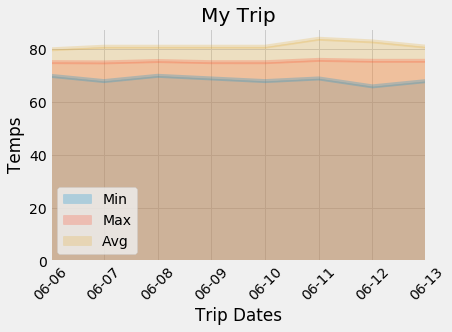

In [58]:
# Plot the daily normals as an area plot with `stacked=False

ax=trip_dates.plot(kind='area',stacked=False, title='My Trip', alpha=.25)
ax.set_xticklabels(trip_dates['Trip Dates'], rotation=45)
ax.set_ylabel('Temps')
ax.set_xlabel('Trip Dates')